In [14]:
# Label(cell) = [c1, c2, .... , c20, Pc, x, y, w, h] : size(20 + 5 = 25)
#                |________________|  |   |________|
#                         |          |        |
#                         |          |     bounding boxes
#                     20 classes   Probability thet there is object

In [15]:
# For 2 anchor boxes
#                                             box 1            box 2
# Predictions(cell) = [c1, c2, .... , c20, Pc1, x, y, w, h, Pc2, x, y, w, h] : size(20 + 5 + 5) = 30
#                      |________________|   |   |________|
#                               |           |        |
#                               |           |    bounding boxes
#                          20 classes   Probability thet there is object

# Note : cell can only detect 1 object 

In [16]:
# Target shape for one image      = (S, S, 25) 
# Prediction shape for one image  = (S, S, 30)

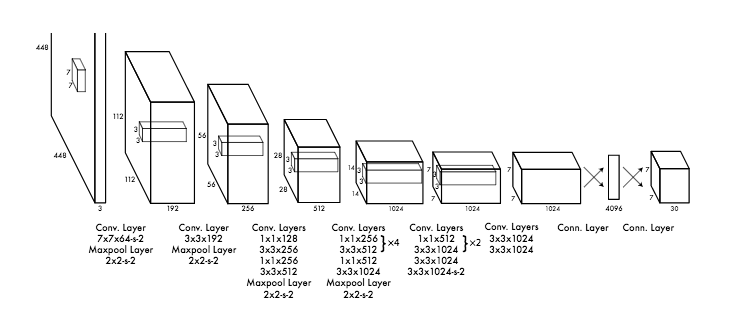

In [17]:
# Input image : 448 x 448 x 3

# First layer
# Conv          : 7 x 7, 64 filters, stride is 2 : output size  = 448/2 x 448/2 x (3x64) = 224 x 224 x 192
# Maxpool layer : 2 x 2,             stride is 2 :  output size = 228/2 x 228/2 x 192    = 112 x 112 x 192

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

# Model

In [18]:
import torch
import torch.nn as nn

In [19]:
# 5 x 5 kernel need padding of 2

# kernel
# padding  padding
#   |    ___|
#  _|_ _|_ ___ ___ ___
# | 1 | 2 | 3 | 4 | 5 | padding
# |___|___|___|___|___|
# | 2 |   |   |   |   | padding
# |___|___|___|___|___|___ ___ ___ ___ ___
# | 3 |   |0,0|0,1|   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___|.......
# | 4 |   |1,0|   |   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___| Image
# | 5 |   |   |   |   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___|.......
#           .                           .
#           .        Image              .
#           .                           .

In [20]:
architecture_config = [
    (7, 64, 2, 3), # kernel size, number of filters, stride, padding (for 7x7 kernel need padding of 3)
    "M", # Maxpool
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # [
    #   (kernel size, number of filters, stride, padding),
    #   (kernel size, number of filters, stride, padding),
    #   number of repeats (4)
    # ]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

i.e. each activation is shifted by its own shift parameter (beta). So yes, the batch normalization eliminates the need for a bias vector. Just a side note: in Pytorch the BN's betas are all initialized to zero by default, whereas the biases in linear and convolutional layers are initialized to random values.

In [21]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1) # 0.1 is the slop

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs) # fcs : fully connected layers

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1] # update in channels to out channels of layer before

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            out_channels=conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1], # in channels is output of conv1
                            out_channels=conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1] # update in channels to out channels of layer before (conv2 out channels)

        return nn.Sequential(*layers) # (*) for unpack the list and use elements as args
                                      # example for (*)
                                      # def print_abc(a, b, c):
                                      #   print(a, b, c)
                                      #
                                      # a = [1, 2, 3]
                                      # print_abc(*a)
                                      # # output : 1 2 3
        
    def _create_fcs(self, split_size, num_boxes, num_classes): # fcs : fully connected layers
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496), # on original paper 4096
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)), # later this will reshape to S x S x 30 where C + (B*5) = 30
        )

In [24]:
def test(S=7, B=2, C=20):
    model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn(2, 3, 448, 448) # 2 examples
    out = model(x)
    print(out)
    print(out.shape)

test() # 1470 later reshape to 7 x 7 x 30

tensor([[ 0.3088,  0.0772,  0.0674,  ..., -0.0834,  0.0205,  0.0703],
        [ 0.0040,  0.1303,  0.1380,  ...,  0.0161, -0.0487,  0.0451]],
       grad_fn=<AddmmBackward0>)
torch.Size([2, 1470])


1470